## EDA Overview - Home-Credit Risk

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [2]:
app_train = pd.read_csv('../data/raw/home_credit/application_train.csv')
app_test = pd.read_csv('../data/raw/home_credit/application_test.csv')
bureau = pd.read_csv('../data/raw/home_credit/bureau.csv')
bureau_balance = pd.read_csv('../data/raw/home_credit/bureau_balance.csv')
prev = pd.read_csv('../data/raw/home_credit/previous_application.csv')
pos = pd.read_csv('../data/raw/home_credit/POS_CASH_balance.csv')
ins = pd.read_csv('../data/raw/home_credit/installments_payments.csv')
cc = pd.read_csv('../data/raw/home_credit/credit_card_balance.csv')

## Project snapshot

In [3]:
def audit(df, name):
    return {
        "dataset": name,
        "rows": len(df),
        "cols": df.shape[1],
        "numeric": df.select_dtypes("number").shape[1],
        "categorical": df.select_dtypes(include=["object","category","bool"]).shape[1],
        "missing_pct_mean": df.isna().mean().mean() * 100,
    }

summary = pd.DataFrame([
    audit(app_train, "application_train"),
    audit(app_test, "application_test"),
    audit(bureau, "bureau"),
    audit(prev, "previous_application"),
    audit(pos, "pos_cash"),
    audit(ins, "installments"),
    audit(cc, "credit_card"),
    audit(bureau_balance, "bureau_balance"),
]).sort_values("rows", ascending=False)
summary


,dataset,rows,cols,numeric,categorical,missing_pct_mean
7,bureau_balance,27299925,3,2,1,0.000000
5,installments,13605401,8,8,0,0.005338
4,pos_cash,10001358,8,7,1,0.065189
6,credit_card,3840312,23,22,1,6.654074
2,bureau,1716428,17,14,3,13.502552
3,previous_application,1670214,37,21,16,17.976877
0,application_train,307511,122,106,16,24.395942
1,application_test,48744,121,105,16,23.811687


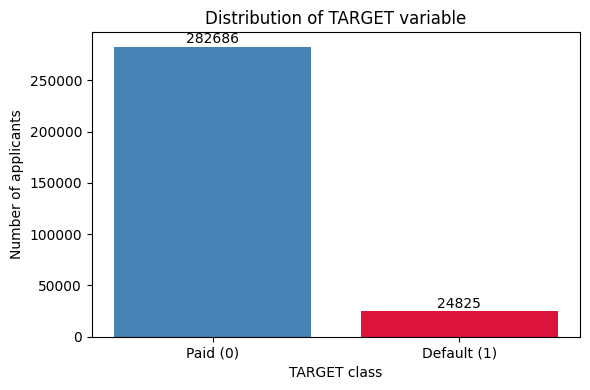

Percentage of unpaid loans (TARGET=1): 8.07%


In [4]:
# Get value counts
target_counts = app_train["TARGET"].value_counts().sort_index()
labels = target_counts.index.map({0: "Paid (0)", 1: "Default (1)"})
colors = ["steelblue", "crimson"]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, target_counts.values, color=colors)

# Add text on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, yval, ha="center", va="bottom")

# Titles and labels
plt.title("Distribution of TARGET variable")
plt.xlabel("TARGET class")
plt.ylabel("Number of applicants")
plt.tight_layout()
plt.show()

# Unpaid loan percentage
unpaid_pct = target_counts.loc[1] / target_counts.sum() * 100
print(f"Percentage of unpaid loans (TARGET=1): {unpaid_pct:.2f}%")

## Coverage and joinability check

In [5]:
aux = {
    "bureau": bureau["SK_ID_CURR"].nunique(),
    "previous": prev["SK_ID_CURR"].nunique(),
    "pos_cash": pos["SK_ID_CURR"].nunique(),
    "installments": ins["SK_ID_CURR"].nunique(),
    "credit_card": cc["SK_ID_CURR"].nunique(),
}
all_customers = app_train["SK_ID_CURR"].nunique() + app_test["SK_ID_CURR"].nunique()
cov = pd.DataFrame([
    {"table": k, "customers": v, "coverage_pct": 100 * v / all_customers}
    for k, v in aux.items()
]).sort_values("coverage_pct", ascending=False)
cov

,table,customers,coverage_pct
3,installments,339587,95.321329
1,previous,338857,95.116419
2,pos_cash,337252,94.665899
0,bureau,305811,85.840479
4,credit_card,103558,29.068504


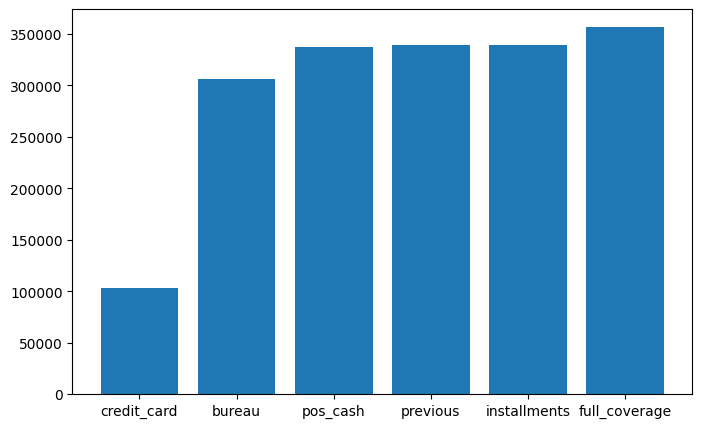

In [6]:
all_customers_entry: dict = {'table':'full_coverage', 'customers':all_customers, 'coverage_pct':100}

plt.figure(figsize=(8,5))

cov.loc[len(cov)] = all_customers_entry
cov = cov.sort_values('coverage_pct', ascending=True)
plt.bar(
    x = cov['table'],
    height = cov['customers'], 
)
plt.show()

## Data quality spotlight

In [7]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)
    
    # Create a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: 'Percentage'})
    
    # Sort the table by percentage of missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        'Percentage', ascending=False).round(1)
    
    # Summary of missing values
    print(f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values. These are the top 15 below:")
    
    return mis_val_table_ren_columns.head(15)

In [8]:
missing_values_table(app_train)

There are 67 columns that have missing values. These are the top 15 below:


,Missing Values,Percentage
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


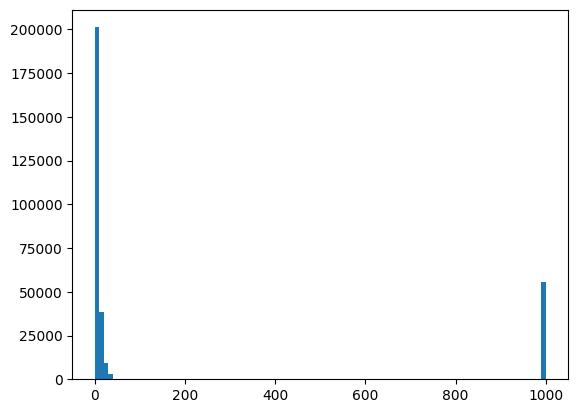

In [9]:
cent_age = 365.25 * 100

age = abs(app_train['DAYS_EMPLOYED'] / 365.25)

plt.hist(
    age,
    bins=100
         )
plt.show()

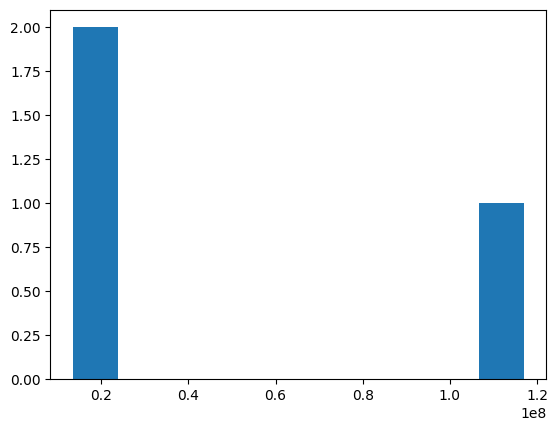

In [10]:
income_over_10_mil = app_train['AMT_INCOME_TOTAL'].loc[app_train['AMT_INCOME_TOTAL'] >= 10_000_000]

plt.hist(
    income_over_10_mil
         )
plt.show()

## LightGBM quick model

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11617
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


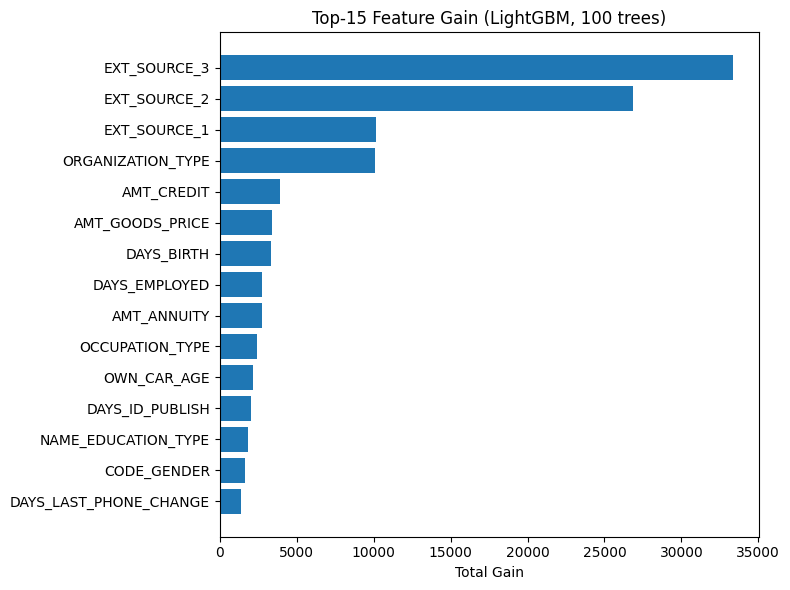

,feature,gain
42,EXT_SOURCE_3,33385.583004
41,EXT_SOURCE_2,26879.217525
40,EXT_SOURCE_1,10121.478529
39,ORGANIZATION_TYPE,10054.457309
7,AMT_CREDIT,3891.832078
9,AMT_GOODS_PRICE,3380.118747
16,DAYS_BIRTH,3326.361454
17,DAYS_EMPLOYED,2766.288356
8,AMT_ANNUITY,2739.171650
27,OCCUPATION_TYPE,2392.851187


In [ ]:
TARGET = "TARGET"

# Detect categoricals and use pandas categoricals
cat_cols = [c for c in app_train.columns if app_train[c].dtype == "object"]
for c in cat_cols:
    app_train[c] = app_train[c].astype("category")

X = app_train.drop(columns=[TARGET])
y = app_train[TARGET]

# quick split
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 100 trees, no tuning
clf = LGBMClassifier(
    objective="binary",
    n_estimators=100,
    random_state=42
)
clf.fit(X_tr, y_tr, categorical_feature=cat_cols)

# Feature gain
booster = clf.booster_
feat_names = booster.feature_name()
gain = booster.feature_importance(importance_type="gain")

imp = (
    pd.DataFrame({"feature": feat_names, "gain": gain})
      .sort_values("gain", ascending=False)
      .head(15)
)

# Bar chart
plt.figure(figsize=(8, 6))
plt.barh(imp["feature"][::-1], imp["gain"][::-1])
plt.title("Top-15 Feature Gain (LightGBM, 100 trees)")
plt.xlabel("Total Gain")
plt.tight_layout()
plt.show()

imp